In [1]:
area_name = 'Shawinigan'
output_folder = f'data/{area_name}'

areal_file = f'{output_folder}/areal.gpkg'
initial_network_file = f'{output_folder}/filtered_network.gpkg'
output_file = f'{output_folder}/output.gpkg'

In [2]:
import geopandas
import pandas as pd
import osmnx as ox
import networkx as nx
import shapely

In [3]:
areal_roads = geopandas.read_file(areal_file)

filtered_edges = geopandas.read_file(initial_network_file, layer="edges")
filtered_nodes = geopandas.read_file(initial_network_file, layer="nodes")

In [4]:
epsg = filtered_edges.crs.to_epsg()
epsg

32618

In [5]:
collection = shapely.geometry.GeometryCollection(list(areal_roads["geometry"]))
area_polygon = collection.convex_hull

In [6]:
filtered_network = ox.graph_from_gdfs(filtered_nodes, filtered_edges.set_index(['u', 'v', 'key']))

filtered_degrees = pd.DataFrame(filtered_network.degree(filtered_nodes["osmid"]))

filtered_degrees.columns = ["nodeid", "degree"]
filtered_degrees = filtered_degrees[filtered_degrees["degree"] > 2]
filtered_degrees.to_csv(f"{output_folder}/{area_name}_filtered_degrees.csv")

In [7]:
carriageways_before_cleanup = geopandas.read_file(output_file, layer="Fifth pass - Snap")
road_widths = carriageways_before_cleanup.groupby("road_uuid").agg({'gem_breedte': 'min', 'dev_breedte': 'min', 'min_breedte': 'min', 'max_breedte': 'min', 'oper_breedte': 'min'})

road_widths["area_name"] = area_name
road_widths.to_csv(f"{output_folder}/{area_name}_widths.csv")

In [8]:
final_cways = geopandas.read_file(output_file, layer="Carriageways")

In [9]:
def is_one_way(f):
    """Returns True if this feature is a one way"""
    
    if f['oneway'] == 'yes':
        return True
    
    if "junction" in f and f["junction"] == "roundabout":
        return True
    
    if "highway" in f and (f["highway"] == "motorway" or f["highway"] == "motorway_link"):
        return True
    
    return False

In [10]:
stats = {}

# Area of convex hull
stats["convex_hull_area"] = area_polygon.area

# Number of polygons
stats["number_of_polygons"] = len(areal_roads)

# Number of LoD1 edges (filtered)
stats["number_of_centerlines"] = len(filtered_edges)

# Directionality of LoD1 edges (with graph)
# TODO

# Polygon to LoD1 edge ratio
stats["polygon_to_centerlines_ratio"] = stats["number_of_polygons"] / stats["number_of_centerlines"]

# Polygon area mean + std + median
stats["polygon_area_mean"] = areal_roads.apply(lambda f: f["geometry"].area, axis=1).mean()
stats["polygon_area_std"] = areal_roads.apply(lambda f: f["geometry"].area, axis=1).std()
stats["polygon_area_median"] = areal_roads.apply(lambda f: f["geometry"].area, axis=1).median()

# Polygon total area
stats["polygon_area_total"] = areal_roads.apply(lambda f: f["geometry"].area, axis=1).sum()

# LoD1 edge length mean + std + median
stats["centerlines_length_mean"] = filtered_edges.apply(lambda f: f["geometry"].length, axis=1).mean()
stats["centerlines_length_std"] = filtered_edges.apply(lambda f: f["geometry"].length, axis=1).std()
stats["centerlines_length_median"] = filtered_edges.apply(lambda f: f["geometry"].length, axis=1).median()

# LoD1 edge total length
stats["centerlines_length_total"] = filtered_edges.apply(lambda f: f["geometry"].length, axis=1).sum()

# LoD1 edge density (total edge length/area)
stats["centerlines_density"] = stats["centerlines_length_total"] / stats["convex_hull_area"]

# Area to LoD1 length ratio
stats["area_to_centerlines_length"] = stats["polygon_area_total"] / stats["centerlines_length_total"]

# Road width mean + std + median
stats["road_width_mean"] = road_widths["oper_breedte"].mean()
stats["road_width_std"] = road_widths["oper_breedte"].std()
stats["road_width_median"] = road_widths["oper_breedte"].median()

stats["road_width_mean_no_outliers"] = road_widths[road_widths.apply(lambda f: f["oper_breedte"] < 15 and f["oper_breedte"] > 2.5, axis=1)]["oper_breedte"].mean()
stats["road_width_std_no_outliers"] = road_widths[road_widths.apply(lambda f: f["oper_breedte"] < 15 and f["oper_breedte"] > 2.5, axis=1)]["oper_breedte"].std()
stats["road_width_median_no_outliers"] = road_widths[road_widths.apply(lambda f: f["oper_breedte"] < 15 and f["oper_breedte"] > 2.5, axis=1)]["oper_breedte"].median()

# Number of twoways (as in OSM)
stats["number_of_twoways"] = len(filtered_edges[filtered_edges.apply(lambda f: not is_one_way(f), axis=1)])
stats["proportion_of_twoways"] = stats["number_of_twoways"] / stats["number_of_centerlines"]

# Number of high outliers (too wide roads)
stats["number_of_high_outliers"] = len(road_widths[road_widths.apply(lambda f: f["oper_breedte"] > 15, axis=1)])
stats["proportion_of_high_outliers"] = stats["number_of_high_outliers"] / stats["number_of_centerlines"]

# Number of low outliers (too narrow roads)
stats["number_of_low_outliers"] = len(road_widths[road_widths.apply(lambda f: f["oper_breedte"] < 2.5, axis=1)])
stats["proportion_of_low_outliers"] = stats["number_of_low_outliers"] / stats["number_of_centerlines"]

# Number of dual carriageways + proportion of all roads
stats["number_of_dual_carriageways"] = len(carriageways_before_cleanup) - len(carriageways_before_cleanup.groupby("road_uuid"))
stats["proportion_of_dual_carriageways"] = stats["number_of_dual_carriageways"] / len(carriageways_before_cleanup.groupby("road_uuid"))

# Number of LoD2 edges + percentage increase from OSM
stats["number_of_carriageways"] = len(final_cways)
stats["carriageways_to_centerlines_ratio"] = len(final_cways) / stats["number_of_centerlines"]

# LoD2 edges length mean + std + median
stats["carriageways_length_mean"] = final_cways.apply(lambda f: f["geometry"].length, axis=1).mean()
stats["carriageways_length_std"] = final_cways.apply(lambda f: f["geometry"].length, axis=1).std()
stats["carriageways_length_median"] = final_cways.apply(lambda f: f["geometry"].length, axis=1).median()

# LoD2 edge total length
stats["carriageways_length_total"] = final_cways.apply(lambda f: f["geometry"].length, axis=1).sum()

# LoD2 edge density (total edge length/area)
stats["carriageways_density"] = stats["carriageways_length_total"] / stats["convex_hull_area"]

# Change in length between LoD1 and LoD2
stats["carriageways_to_centerlines_length_diff"] = stats["carriageways_length_total"] - stats["centerlines_length_total"]
stats["carriageways_to_centerlines_length_perc"] = (stats["carriageways_length_total"] - stats["centerlines_length_total"]) / stats["centerlines_length_total"]

# Change in mean length between LoD1 and LoD2
stats["carriageways_to_centerlines_mean_length_diff"] = stats["carriageways_length_mean"] - stats["centerlines_length_mean"]
stats["carriageways_to_centerlines_mean_length_perc"] = (stats["carriageways_length_mean"] - stats["centerlines_length_mean"]) / stats["centerlines_length_mean"]

# Number of intersections
stats["lod1_number_of_intersection"] = len(filtered_network.nodes())

# Intersection Density per m²
stats["lod1_intersection_density"] = stats["lod1_number_of_intersection"] / stats["convex_hull_area"]

# Number of edges per node average + std + median + mode
stats["lod1_nodes_degree_mean"] = filtered_degrees["degree"].mean()
stats["lod1_nodes_degree_std"] = filtered_degrees["degree"].std()
stats["lod1_nodes_degree_median"] = filtered_degrees["degree"].median()
stats["lod1_nodes_degree_mode"] = filtered_degrees["degree"].mode()[0] if len(filtered_degrees["degree"].mode()) == 1 else list(filtered_degrees["degree"].mode())

# Number of dead-ends
stats["lod1_number_of_deadends"] = len([k for k, v in dict(filtered_network.degree(filtered_nodes["osmid"])).items() if v == 1])

# LoD2 CC
stats["lod1_connected_components"] = nx.number_weakly_connected_components(filtered_network)

# Percent of edges in largest CC
stats["lod1_edges_in_largest_cc_perc"] = len(filtered_network.subgraph(max(nx.weakly_connected_components(filtered_network), key=len)).edges()) / len(filtered_network.edges()) * 100

# Recreate the carriageways network

In [11]:
from shapely.geometry import LineString, MultiLineString
import numpy as np

all_cways = final_cways

def fix_precision(geom, decimals=3):
    if geom.type == "LineString":
        return LineString([np.round(p, decimals) for p in geom.coords])
    elif geom.type == "MultiLineString":
        lines = []
        for l in geom.geoms:
            lines.append(fix_precision(l))
        return MultiLineString(lines)

def get_lexicographic_boundaries(f):
    round_geom = fix_precision(f['geometry'])
    
    try:
        return [str(round_geom.coords[0]), str(round_geom.coords[-1])]
    except Exception as e:
        print(f['uuid'])
        raise e

tmp = all_cways.apply(get_lexicographic_boundaries, axis=1)
all_cways['u_node'] = [a[0] for a in tmp]
all_cways['v_node'] = [a[1] for a in tmp]

nodes = set(list(pd.unique(all_cways['u_node'])) + list(pd.unique(all_cways['v_node'])))

node_map = {}
for uuid, n in enumerate(nodes):
    node_map[n] = uuid

def get_node_uuid(f):
    return [node_map[f['u_node']], node_map[f['v_node']]]

tmp = all_cways.apply(get_node_uuid, axis=1)
all_cways['u'] = [a[0] for a in tmp]
all_cways['v'] = [a[1] for a in tmp]

tab = { "osmid": [], "geometry": [] }
for g in node_map:
    tab["osmid"].append(node_map[g])
    tab["geometry"].append(shapely.wkt.loads("POINT{}".format(g.replace(",", ""))))

cway_nodes = geopandas.GeoDataFrame(tab, geometry="geometry", crs=f"EPSG:{epsg}")

all_cways["geometry"] = all_cways.apply(lambda f: fix_precision(f["geometry"]), axis=1)

final_network = ox.graph_from_gdfs(cway_nodes, all_cways.set_index(["u", "v", "key"]))

In [12]:
degrees = pd.DataFrame(final_network.degree(cway_nodes["osmid"]))

degrees.columns = ["nodeid", "degree"]
degrees = degrees[degrees["degree"] > 2]
degrees.to_csv(f"{output_folder}/{area_name}_cway_degrees.csv")

# LoD2 CC
stats["cway_connected_components"] = nx.number_weakly_connected_components(final_network)

# Percent of edges in largest CC
stats["cway_edges_in_largest_cc_perc"] = len(final_network.subgraph(max(nx.weakly_connected_components(final_network), key=len)).edges()) / len(final_network.edges()) * 100

In [13]:
from tqdm.notebook import trange, tqdm

filtered_network = ox.graph_from_gdfs(filtered_nodes.set_index("osmid"), filtered_edges.set_index(["u", "v", "key"]))

intersection_types = {}

for osmid in tqdm(filtered_network.nodes()):
    deg = filtered_network.degree(osmid)
    if deg < 3:
        continue

    road_uuids = [a["uuid"] for u, v, a in filtered_network.in_edges(osmid, data=True)] + [a["uuid"] for u, v, a in filtered_network.out_edges(osmid, data=True)]
    incident_edges = carriageways_before_cleanup[carriageways_before_cleanup["road_uuid"].isin(road_uuids)]

    duals = int(len(incident_edges[incident_edges["dual"] == True]) / 2)
    singles = len(incident_edges[incident_edges["dual"] == False])

    type_name = f"{deg}_degree_{duals}_dual_{singles}_single"
    if not type_name in intersection_types:
        intersection_types[type_name] = 0

    intersection_types[type_name] = intersection_types[type_name] + 1

intersection_types = {k: v for k, v in sorted(intersection_types.items(), reverse=True)}

  0%|          | 0/3694 [00:00<?, ?it/s]

In [18]:
# Find false dead-ends
false_deadends = []

for osmid, node_data in tqdm(final_network.nodes(data=True)):
    deg = final_network.degree(osmid)
    if deg != 1:
        continue

    road_uuids = [a["road_uuid"] for u, v, a in final_network.in_edges(osmid, data=True)] + [a["road_uuid"] for u, v, a in final_network.out_edges(osmid, data=True)]
    
    assert len(road_uuids) == 1

    road_uuid = road_uuids[0]

    u = filtered_edges[filtered_edges["uuid"] == road_uuid]["u"].iloc[0]
    v = filtered_edges[filtered_edges["uuid"] == road_uuid]["v"].iloc[0]

    if filtered_network.degree(u) > 1 and filtered_network.degree(v) > 1:
        false_deadends.append(node_data)

  0%|          | 0/11665 [00:00<?, ?it/s]

In [49]:
# Number of intersections
stats["cway_number_of_intersection"] = len(cway_nodes)

# Percentage increase of intersections between cways and centrelines
stats["cway_to_centreline_intersections_perc"] = stats["cway_number_of_intersection"] / len(filtered_nodes)

# Intersection Density per m²
stats["cway_intersection_density"] = stats["cway_number_of_intersection"] / stats["convex_hull_area"]

# Number of edges per node average + std + median + mode
stats["cway_nodes_degree_mean"] = degrees["degree"].mean()
stats["cway_nodes_degree_std"] = degrees["degree"].std()
stats["cway_nodes_degree_median"] = degrees["degree"].median()
stats["cway_nodes_degree_mode"] = degrees["degree"].mode()[0] if len(degrees["degree"].mode()) == 1 else list(degrees["degree"].mode())

# Number of dead-ends
stats["cway_number_of_deadends"] = len([k for k, v in dict(final_network.degree(final_network.nodes())).items() if v == 1])

for k in intersection_types.keys():
    stats[f"number_of_{k}"] = intersection_types[k]

stats["false_deadends"] = len(false_deadends)
stats["false_deadends_perc"] = stats["false_deadends"] / len(final_network.nodes()) * 100

stats


{'convex_hull_area': 688531584.4982995,
 'number_of_polygons': 4443,
 'number_of_centerlines': 5045,
 'polygon_to_centerlines_ratio': 0.8806739345887017,
 'polygon_area_mean': 1582.441683438919,
 'polygon_area_std': 4022.5998126974123,
 'polygon_area_median': 968.7517719569602,
 'polygon_area_total': 7030788.399519117,
 'centerlines_length_mean': 182.6392614937294,
 'centerlines_length_std': 361.74400471774777,
 'centerlines_length_median': 93.65702426079503,
 'centerlines_length_total': 921415.0742358648,
 'centerlines_density': 0.0013382321087089368,
 'area_to_centerlines_length': 7.630424763074115,
 'road_width_mean': 9.071938553022795,
 'road_width_std': 5.718293852527377,
 'road_width_median': 9.22,
 'road_width_mean_no_outliers': 9.545464,
 'road_width_std_no_outliers': 2.5637700707937077,
 'road_width_median_no_outliers': 9.504999999999999,
 'number_of_twoways': 4454,
 'proportion_of_twoways': 0.8828543111992071,
 'number_of_high_outliers': 495,
 'proportion_of_high_outliers': 0

In [25]:
stats_df = pd.DataFrame.from_dict(stats, orient="index", columns=["value"])
stats_df.to_csv(f"{output_folder}/{area_name}_stats.csv")

geopandas.GeoDataFrame(false_deadends, crs=f"EPSG:{epsg}").to_file(f"{output_folder}/{area_name}_false_deadends.gpkg", driver='GPKG')

# Create cool directionality plots

In [31]:
# Compute the bearing and make the cool graphs
Gu = ox.add_edge_bearings(ox.get_undirected(filtered_network))
weight_by_length = True

def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

# weight bearings by length (meters)
if weight_by_length:
    # weight bearings by length (meters)
    city_bearings = []
    for u, v, k, d in Gu.edges(keys=True, data=True):
        city_bearings.extend([d['bearing']] * int(d['length']))
    b = pd.Series(city_bearings)
    bearings = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
else:
    # don't weight bearings, just take one value per street segment
    b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
    bearings = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

0          313.5
1          313.5
2          313.5
3          313.5
4          313.5
           ...  
1835503    284.2
1835504    284.2
1835505    284.2
1835506    284.2
1835507    284.2
Length: 1835508, dtype: float64

In [32]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'DejaVu Sans', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'DejaVu Sans', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'DejaVu Sans', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

# create figure and axes
n = 1
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
polar_plot(axes, bearings.dropna(), title=area_name)

# add super title and save full image
suptitle_font = {'family':'DejaVu Sans', 'fontsize':60, 'fontweight':'normal', 'y':1.07}
fig.suptitle('City Street Network Orientation', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
fig.savefig(f'{output_folder}/{area_name}-street-orientations.png', dpi=120, bbox_inches='tight')
plt.close()

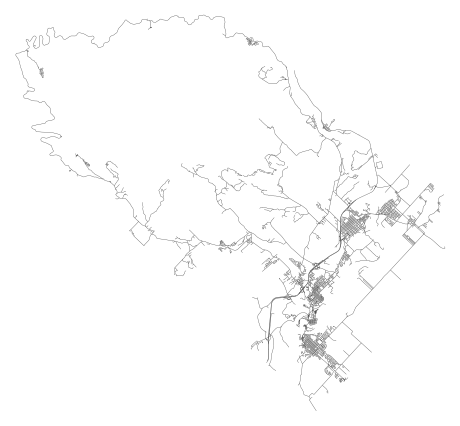

In [46]:
fig, ax = ox.plot_graph(filtered_network, show=False, close=False, bgcolor='w', edge_color='#333333', edge_linewidth=0.3, node_size=0)

# plot each city's polar histogram
polar_plot(axes, bearings.dropna(), title=area_name)

fig.savefig(f'{output_folder}/{area_name}-network.png', dpi=120)

In [17]:
# Percentage overlap between linear and areal
centerlines_geom = filtered_edges["geometry"].unary_union
polygons_geom = areal_roads["geometry"].unary_union
# centerlines_geom.intersection(polygons_geom)